# Support Vector Machine

## Load Data

In [1]:
from pathlib import Path

import pandas as pd

In [2]:
from sklearn.utils import shuffle

base_directory = Path(r'/media/thor/PortableSSD/mydata/emojihero/dataset/dataset-face-expression-csv')
train_df = pd.read_csv(base_directory / 'training_set.csv')
val_df = pd.read_csv(base_directory / 'validation_set.csv')

SEED = 42
train_df = shuffle(train_df, random_state=SEED)
val_df = shuffle(val_df, random_state=SEED)

print(f'Number of Training Samples: {len(train_df)}')
print(train_df['Label'].value_counts())
print(f'Number of Validation Samples: {len(val_df)}')
print(val_df['Label'].value_counts())

train_df.head()

Number of Training Samples: 964
Label
0    197
1    191
3    172
2    131
4    105
5    102
6     66
Name: count, dtype: int64
Number of Validation Samples: 385
Label
5    55
4    55
1    55
2    55
6    55
0    55
3    55
Name: count, dtype: int64


,timestamp,participant_id,FAU_0,FAU_1,FAU_2,FAU_3,FAU_4,FAU_5,FAU_6,FAU_7,...,FAU_54,FAU_55,FAU_56,FAU_57,FAU_58,FAU_59,FAU_60,FAU_61,FAU_62,Label
760,1700488114760,3,0.107896,0.194889,1.401298e-45,1.320220e-22,0.024912,0.024321,1.401298e-45,1.401298e-45,...,9.209801e-21,2.610711e-37,1.000182e-13,5.099260e-05,1.002689e-02,4.672041e-07,2.050273e-07,5.688704e-02,8.172417e-02,4
884,1700748819058,16,0.834857,0.764817,1.026462e-20,2.168397e-11,0.416924,0.377339,2.632983e-03,1.401298e-45,...,2.479763e-03,2.194700e-01,2.563659e-01,1.888640e-06,5.865657e-03,8.533958e-10,2.958799e-04,1.071407e-02,2.710130e-02,5
938,1701357565849,34,0.131417,0.130338,1.680341e-04,1.439196e-04,0.252091,0.225658,0.000000e+00,0.000000e+00,...,1.401298e-45,1.083556e-02,1.089628e-02,2.802597e-45,1.980103e-34,1.401298e-45,1.401298e-45,2.718902e-01,2.924575e-01,5
901,1700827807807,21,0.615232,0.514535,9.174733e-03,9.058302e-03,0.389754,0.374438,0.000000e+00,0.000000e+00,...,2.141047e-02,9.831126e-01,9.945938e-01,8.538091e-03,4.727362e-02,9.986752e-05,4.469715e-06,3.522862e-01,4.055933e-01,5
622,1700748690839,16,0.000001,0.000020,1.059425e-02,1.085821e-02,0.010866,0.000002,1.401298e-45,0.000000e+00,...,7.473406e-12,5.651674e-10,1.086265e-02,1.238884e-02,9.620150e-03,1.538864e-01,1.280742e-01,1.139681e-12,6.957371e-13,3


In [3]:
import numpy as np
from sklearn.model_selection import PredefinedSplit

X_train = train_df.drop(['Label', 'timestamp', 'participant_id'], axis=1)
y_train = train_df['Label']
X_val = val_df.drop(['Label', 'timestamp', 'participant_id'], axis=1)
y_val = val_df['Label']
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

train_indices = -1 * np.ones(len(train_df), dtype=int)
val_indices = np.zeros(len(val_df), dtype=int)
split_index = np.concatenate((train_indices, val_indices))
ps = PredefinedSplit(split_index)

## Find optimal Hyperparameters via GridSearch

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=SEED))
])

param_grid = {
    'svc__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 10],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__degree': [1, 2, 3, 4, 5],
    'svc__gamma': ['scale', 'auto'],
    'svc__class_weight': [None, 'balanced'],
    'svc__tol': [1e-3, 1e-4]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=ps, refit=False, scoring='accuracy', n_jobs=-1, verbose=2)

In [5]:
import time

start_time = time.time()
grid_search.fit(X_combined, y_combined)
end_time = time.time()

print(f'GridSearch took: {end_time - start_time:.2f} seconds.')

Fitting 1 folds for each of 1120 candidates, totalling 1120 fits
GridSearch took: 3.83 seconds.


In [6]:
best_parameters = grid_search.best_params_
print('Best Parameters:', best_parameters)
print('Best Cross-Validation-Accuracy:', grid_search.best_score_)

Best Parameters: {'svc__C': 0.05, 'svc__class_weight': 'balanced', 'svc__degree': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__tol': 0.001}
Best Cross-Validation-Accuracy: 0.8051948051948052


## Evaluation

In [7]:
best_parameters = {k.replace('svc__', ''): v for k, v in best_parameters.items()}
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(**best_parameters, random_state=SEED))
])

best_model.fit(X_train, y_train)
print(f'Trained model on training set with optimal hyperparameters: {best_parameters}')

Trained model on training set with optimal hyperparameters: {'C': 0.05, 'class_weight': 'balanced', 'degree': 1, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.001}


In [8]:
from sklearn.metrics import accuracy_score

y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with optimized Hyperparameters: {val_accuracy:.4f}")

Validation Accuracy with optimized Hyperparameters: 0.8052


In [9]:
test_df = pd.read_csv(base_directory / 'test_set.csv')
print(f'Number of Test Samples: {len(test_df)}')
X_test, y_test = test_df.drop(['Label', 'timestamp', 'participant_id'], axis=1), test_df['Label']

Number of Test Samples: 378


In [10]:
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with optimized Hyperparameters: {test_accuracy:.4f}")

Test Accuracy with optimized Hyperparameters: 0.7143


In [11]:
from sklearn.metrics import classification_report

emotion_to_id = {'Neutral': 0, 'Happiness': 1, 'Sadness': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6}

print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=emotion_to_id.keys(), digits=4))

Classification Report (Test Set):
              precision    recall  f1-score   support

     Neutral     0.6812    0.8704    0.7642        54
   Happiness     0.7910    0.9815    0.8760        54
     Sadness     0.9268    0.7037    0.8000        54
    Surprise     0.7778    0.7778    0.7778        54
        Fear     0.5926    0.5926    0.5926        54
     Disgust     0.5593    0.6111    0.5841        54
       Anger     0.7353    0.4630    0.5682        54

    accuracy                         0.7143       378
   macro avg     0.7234    0.7143    0.7090       378
weighted avg     0.7234    0.7143    0.7090       378



Confusion Matrix, without normalization
[[47  2  1  0  4  0  0]
 [ 0 53  0  0  1  0  0]
 [ 8  0 38  0  2  1  5]
 [ 2  0  0 42 10  0  0]
 [ 7  3  0  9 32  3  0]
 [ 0  7  2  3  5 33  4]
 [ 5  2  0  0  0 22 25]]


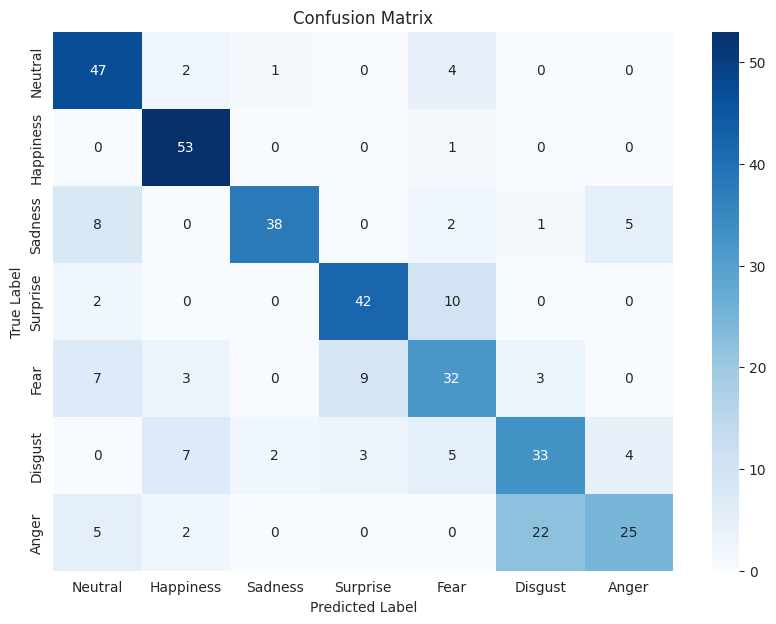

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


plot_confusion_matrix(y_test, y_test_pred, classes=emotion_to_id.keys(), title='Confusion Matrix')